<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data" data-toc-modified-id="Filter-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Filter data</a></span></li><li><span><a href="#Filter-holdings" data-toc-modified-id="Filter-holdings-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filter holdings</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Other functions</a></span></li><li><span><a href="#Cluster-with-Spectral-Clustering" data-toc-modified-id="Cluster-with-Spectral-Clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cluster with Spectral Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Options</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize</a></span></li><li><span><a href="#Chart-the-returns-of-the-formed-clustes" data-toc-modified-id="Chart-the-returns-of-the-formed-clustes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Chart the returns of the formed clustes</a></span></li><li><span><a href="#Analysing-clusters" data-toc-modified-id="Analysing-clusters-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Analysing clusters</a></span></li></ul></div>

# Clustering

## Description

- Cluster funds using k-means

## Setup

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import Normalizer

### Load Data

In [3]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

### Filter data 

In [4]:
row_info_f = row_info.query('year == @year')

begin_date = row_info_f.iloc[0,:]['report_dt']
end_date = begin_date + pd.DateOffset(years=1,months=1,days = 5)
row_info_f.reset_index(drop = True, inplace=True)

# Filter returns
crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
returns_f = returns.copy()
query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
returns_f = returns_f.query(query)

# Change return of month for which holdings apply to 0
mask = returns_f['report_dt'] == begin_date
returns_f.loc[mask,'mret'] = 0

# Filter holdings accordingly and delet all empty columns
holdings_f = holdings[row_info_f['row']]
col_sums = pd.DataFrame(holdings_f.sum(0).T).values 
mask = (col_sums != 0).flatten()
holdings_f = holdings_f[:,mask]

print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))
print('Numer of unique securities:      {:10,d}'.format(holdings_f.shape[1]))
print('Begin date:                      {}'.format(begin_date.date()))
print('End date:                        {}'.format(end_date.date()))

Numer of unique funds:                1,839
Numer of unique securities:           5,572
Begin date:                      2015-12-31
End date:                        2017-02-05


### Filter holdings

In [5]:
# Generate sparse holdings matrix with boolean values instead of more precise percent_tna values
holdings_b = sparse.csr_matrix(holdings_f, copy=True)
holdings_b.data = np.ones(len(holdings.data))

In [6]:
# Each security has to appear at least x times stocks
sum_sec_boolean = holdings_b.toarray().sum(0)
col_mask = (sum_sec_boolean >= 2).flatten()

holdings_f = holdings_f.tocsc()
holdings_f = holdings_f[:,col_mask]
holdings_f = holdings_f.tocsr()

np.sum(col_mask)

5072

## Preprocessing

In [7]:
transformer = Normalizer().fit(holdings_f)
holdings_ft = transformer.transform(holdings_f)

In [8]:
holdings_f

<1839x5072 sparse matrix of type '<class 'numpy.float64'>'
	with 243239 stored elements in Compressed Sparse Row format>

In [9]:
holdings_ft

<1839x5072 sparse matrix of type '<class 'numpy.float64'>'
	with 243239 stored elements in Compressed Sparse Row format>

## Other functions

In [83]:
def plot_cluster(row_info_f,style):
    sns.set()
    sns.set_style("white")
    data = round(
        pd.crosstab(
            row_info_f[style],row_info_f['cluster'], 
            margins = True, normalize = 'columns') * 100, 2).T

    ax = data.plot(kind='bar', 
                 stacked=True, 
                 figsize=(15,2))

    #ax.legend(bbox_to_anchor=(1, 1))
    ax.legend().remove()
    label_list = data.columns.values.astype(str).repeat(data.shape[0])
    rects = ax.patches

    # For each bar: Place a label
    for i, rect in enumerate(rects):
        if rect.get_height() > 10:
            # Get X and Y placement of label from rect.
            x_value = rect.get_x() + rect.get_width() / 2
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 0


            # Use X value as label and format number with one decimal place
            label = "{}".format(label_list[i])

            # Create annotation
            plt.annotate(
                label,                        # Use `label` as label
                (x_value, y_value),           # Place label at end of the bar
                xytext = (space, 0),          # Horizontally shift label by `space`
                textcoords = 'offset points', # Interpret `xytext` as offset in points
                va='center',                  # Vertically center label
                ha='center',
                color = 'white',
                size = 12)                  # Horizontally align label 
    plt.show()

## Cluster with Spectral Clustering

### Options

In [84]:
year             = 2016
style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class

In [85]:
print('Start clustering...')
clustering = SpectralClustering(n_clusters = 6,
                                assign_labels = 'discretize', # kmeans or discretize
                                eigen_solver = 'arpack',
                                n_init = 100,
                                n_jobs = -1,
                                random_state = 0).fit(holdings_ft)

row_info_f = row_info_f.assign(cluster = clustering.labels_)
print('Clustering finished')

Start clustering...
Clustering finished


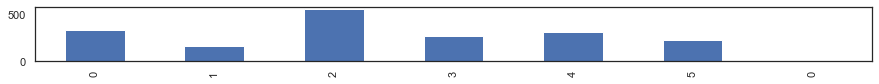

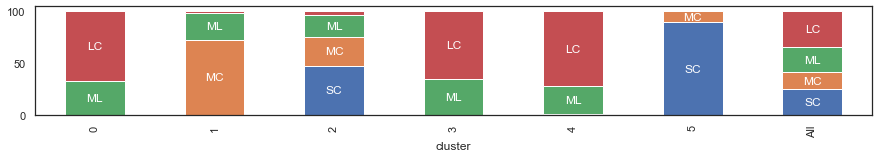

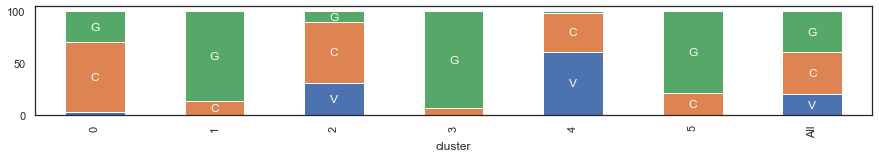

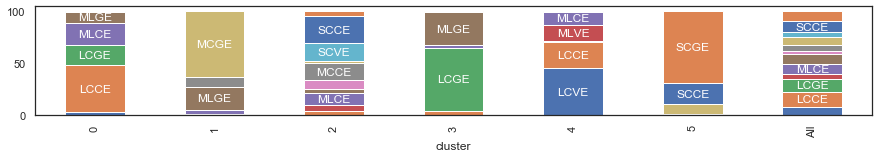

In [86]:
data = row_info_f['cluster'].value_counts(sort=False).append(to_append = pd.Series([0]))

data.plot(kind='bar', figsize = (15,1))
plot_cluster(row_info_f,'cap_class')
plot_cluster(row_info_f,'style_class')
plot_cluster(row_info_f,'lipper_class')

## Visualize

In [ ]:
### Based on example code from sklearn ###

X = holdings_ft
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,18,25]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(X)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          'The average silhouette_score is: {}'.format(round(silhouette_avg,4)))

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Chart the returns of the formed clustes

In [ ]:
row_info.sample()

#### Merge new clusters into returns

In [ ]:
returns_merged = returns.merge(row_info, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','crsp_portno','mret','lipper_class','cluster']]
returns_merged.sample()

#### Calc mean return per Obj_cd

In [ ]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

In [ ]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [ ]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

In [ ]:
plt.plot(kmeans.cluster_centers_[0,:])

In [ ]:
plt.plot(kmeans.cluster_centers_[1,:])